In [1]:
import pandas as pd
import numpy as np

In [2]:
path = '../thermofeeler/data/tokenized_dataset.csv'
df = pd.read_csv(path)
df = df.drop(columns=['Unnamed: 0'])

In [3]:
df_pos = df[df.encoded_sentiment == 1].sample(7000)
df_neg = df[df.encoded_sentiment == -1].sample(7000)
df_net = df[df.encoded_sentiment == 0].sample(7000)

In [4]:
small_df = pd.concat([df_pos, df_neg, df_net])

In [5]:
small_df.encoded_sentiment.value_counts()

 1    7000
-1    7000
 0    7000
Name: encoded_sentiment, dtype: int64

In [6]:
X = small_df.tweet_text
y = small_df.encoded_sentiment
y = pd.get_dummies(y)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14699,), (6301,), (14699, 3), (6301, 3))

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
tk = Tokenizer()
tk.fit_on_texts(X_train)
X_train_token = tk.texts_to_sequences(X_train)
X_train_token[0]

[70, 3269, 249, 318, 754, 1, 1028, 5, 273]

In [11]:
maxLength = max(len(x) for x in X_train_token)
minLength = min(len(x) for x in X_train_token)
vocab_size = len(tk.word_index)
maxLength, minLength, vocab_size

(43, 0, 22947)

In [12]:
X_train_pad = pad_sequences(X_train_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_train_pad[0]

array([  70, 3269,  249,  318,  754,    1, 1028,    5,  273,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [47]:
def initialize_model():
    
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.01, l2=0.01)
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model = Sequential()
    embedding_size = 200
    model.add(Embedding(input_dim = vocab_size+1, input_length=50,
                        output_dim=embedding_size, mask_zero=True))
    
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu', kernel_regularizer=reg_l2))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax", kernel_regularizer=reg_l2))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

    return model

In [48]:
model = initialize_model()
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[es], validation_split=0.2 );

Epoch 1/200
368/368 [==============================] - 19s 43ms/step - loss: 1.5219 - accuracy: 0.4625 - val_loss: 1.4103 - val_accuracy: 0.6480
Epoch 2/200
368/368 [==============================] - 15s 39ms/step - loss: 1.2586 - accuracy: 0.6395 - val_loss: 1.0823 - val_accuracy: 0.6861
Epoch 3/200
368/368 [==============================] - 15s 40ms/step - loss: 0.9908 - accuracy: 0.6735 - val_loss: 0.9162 - val_accuracy: 0.6793
Epoch 4/200
368/368 [==============================] - 15s 40ms/step - loss: 0.8532 - accuracy: 0.6876 - val_loss: 0.8114 - val_accuracy: 0.7071
Epoch 5/200
368/368 [==============================] - 17s 47ms/step - loss: 0.7503 - accuracy: 0.7112 - val_loss: 0.7261 - val_accuracy: 0.7371
Epoch 6/200
368/368 [==============================] - 15s 41ms/step - loss: 0.6772 - accuracy: 0.7476 - val_loss: 0.6714 - val_accuracy: 0.7588
Epoch 7/200
368/368 [==============================] - 14s 39ms/step - loss: 0.6122 - accuracy: 0.7874 - val_loss: 0.6314 - val_ac

In [49]:
 model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 200)           4589600   
                                                                 
 lstm_7 (LSTM)               (None, 50)                50200     
                                                                 
 dropout_12 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 3)                 153       
                                                                 
Total params: 4,642,503
Trainable params: 4,642,503
No

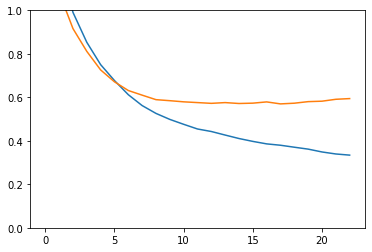

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1));

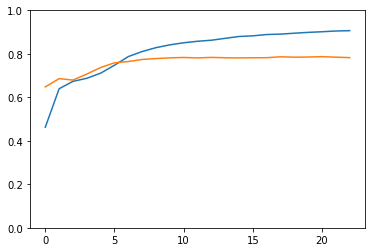

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim((0,1));

In [19]:
X_test_token = tk.texts_to_sequences(X_test)

In [20]:
X_test_pad = pad_sequences(X_test_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_test_pad[0]

array([   73,  2012,  3069,  1704,  1885,   659,  1747,   694, 15166,
         105,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [55]:
model.evaluate(X_test_pad, y_test, verbose=0)

[0.5444003939628601, 0.8032058477401733]

In [ ]:
std_list = {'eh': 'é', 
            'vc': 'você', 
            'vcs': 'vocês',
            'tb': 'também',
            'tambem':'também'
            'tbm': 'também', 
            'obg': 'obrigado',
            'obrigada' : 'obrigado'
            'gnt': 'gente', 
            'q': 'que', 
            'n': 'não', 
            'cmg': 'comigo', 
            'p': 'para',
            'pra' :'para'
            'ta': 'está',
            'tá' : 'está',
            'to': 'estou', 
            'vdd': 'verdade'
            'bjos' : 'beijo',
            'bjo' : 'beijo',
            'kd': 'cadê',
            'cade', 'cadê',
            'ha' : 'há',
            'cmg' : 'comigo',
            'cm' : 'com',
            'pc' : 'cá',
            'aq' : 'aqui'
            'qdo' : 'quando',
            'tem' : 'tém'
            'p' : 'para',
            'k' : 'que'}

In [85]:
letters = ['a','e','h','i','k','o','u','y']

def remove_onomatopeia (tweets):
   # for tweet in tweets :
    for word in tweets :
        if word.count('k') >= 2: 
            word_ = 'kkkk'
            tweets[tweets.index(word)] = word_
            results = tweets
            
        if word.count('ah') >=2:
            word_ = 'ah'
            tweets[tweets.index(word)] = word_
            results = tweets
        
        for letter in word :
            if word.startswith(f'{letter}{letter}') or word.endswith(f'{letter}{letter}'):
                word_ = f'{letter}{}
                tweets[tweets.index(word)] = word_
                results = tweets
        
    return results

In [87]:
kkkk(['ta', 'kk', 'kkkkkkkkk', 'fbqhjbv', 'bcb', 'ahaha', 'ah', 'hahahaha', 'aaaaaaah'])

['ta', 'kkkk', 'kkkk', 'fbqhjbv', 'bcb', 'ah', 'ah', 'ah', 'aaaaaaah']